# ABM vs ODE Model Comparison

This notebook compares the agent-based model (ABM) with the dynamical system (ODE) model for the 2-site, 2-allele SARS-CoV-2 allele-based model.

## Environment Setup

In [1]:
import itertools as it
import functools
import random
from typing import Dict, List, Tuple

try:
    import cupy as cp
except ImportError:
    import numpy as cp
from IPython.display import display_html
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.integrate import solve_ivp
from tqdm.auto import tqdm

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
use_cupy = False  # use numpy backend for consistency
xp = [np, cp][use_cupy]

## Shared Parameters

Define parameters that will be used by both models to ensure fair comparison.

In [3]:
# Shared parameters for both models
SHARED_PARAMS = {
    "N_SITES": 2,  # 2 sites means 4 alleles (0,1,2,3)
    "BASE_B": 0.3,  # base transmission rate per allele
    "CONTACT_RATE": 0.5,
    "RECOVERY_RATE": 0.1,
    "WANING_RATE": 0.003,  # rate of immunity waning (2->1 and 1->0)
    "IMMUNE_STRENGTH": 0.7,  # immunity reduction factor
    "WANED_STRENGTH": 0.05,  # residual immunity after full waning
    "MUTATION_RATE": 0.0,  # no mutation for cleaner comparison
    "DEATH_RATE": 1e-4,  # demographic turnover
}

# ABM-specific parameters
POP_SIZE = 1_000_000
N_STEPS = 600
N_REP = 3

## Agent-Based Model (ABM) Implementation

In [4]:
# State Constants
S: int = 0
I: int = 1
R: int = 2


def simulate_abm(
    N_SITES: int = 2,
    POP_SIZE: int = 1_000_000,
    BASE_B: float = 0.3,
    CONTACT_RATE: float = 0.5,
    RECOVERY_RATE: float = 0.1,
    MUTATION_RATE: float = 0.0,
    WANING_RATE: float = 0.003,
    IMMUNE_STRENGTH: float = 0.7,
    WANED_STRENGTH: float = 0.05,
    DEATH_RATE: float = 1e-4,
    N_STEPS: int = 1000,
    seed: int = 1,
) -> pd.DataFrame:
    random.seed(seed)
    np.random.seed(seed)
    xp.random.seed(seed)

    def initialize_pop() -> Tuple[xp.ndarray, xp.ndarray, xp.ndarray]:
        """Initialize population statuses, genomes, and immune history."""
        pathogen_genomes = xp.zeros(shape=POP_SIZE, dtype=xp.uint8)
        host_immunities = xp.full(
            shape=(POP_SIZE, 2 * N_SITES), fill_value=3, dtype=xp.int8
        )
        host_statuses = xp.full(shape=POP_SIZE, fill_value=S, dtype=xp.uint8)
        return host_statuses, pathogen_genomes, host_immunities

    def infect_initial(
        host_statuses: xp.ndarray,
        pathogen_genomes: xp.ndarray,
        seed_count: int = 10,  # 10/1M = 1e-5 initial prevalence
    ) -> Tuple[xp.ndarray, xp.ndarray]:
        """Seed the initial infection wave with the starting strain (0,2)."""
        host_statuses[:seed_count] = I
        pathogen_genomes[:seed_count] = 0  # genome 0 = strain (0,2)
        return host_statuses, pathogen_genomes

    def get_kappa(host_immunities: xp.ndarray) -> xp.ndarray:
        """Numerical value assigned to immunity levels (kappa)."""
        kappas = xp.zeros_like(host_immunities, dtype=xp.float32)
        kappas[(host_immunities == 2) | (host_immunities == 1)] = 1.0
        kappas[host_immunities == 0] = WANED_STRENGTH
        return kappas

    def update_waning(host_immunities: xp.ndarray) -> xp.ndarray:
        """Transition immunity levels over time (2 -> 1 -> 0)."""
        for level in [2, 1]:
            mask = (host_immunities == level) & (
                xp.random.rand(*host_immunities.shape) < WANING_RATE
            )
            host_immunities[mask] -= 1
        return host_immunities

    def update_recoveries(
        host_statuses: xp.ndarray,
        pathogen_genomes: xp.ndarray,
        host_immunities: xp.ndarray,
    ) -> Tuple[xp.ndarray, xp.ndarray]:
        """Recover infected individuals and reset allele immunity to Level 2."""
        inf_mask = host_statuses == I
        rec_mask = inf_mask & (xp.random.rand(POP_SIZE) < RECOVERY_RATE)
        indices = xp.where(rec_mask)[0]

        if indices.size > 0:
            g = pathogen_genomes[indices][:, None]
            shifts = xp.arange(N_SITES, dtype=xp.uint64)
            bits = (g >> shifts) & xp.uint8(1)
            allele_indices = (2 * xp.arange(N_SITES) + bits).astype(int)

            row_idx = xp.repeat(indices, N_SITES)
            col_idx = allele_indices.flatten()
            host_immunities[row_idx, col_idx] = 2
            host_statuses[indices] = R
        return host_statuses, host_immunities

    def update_infections(
        host_statuses: xp.ndarray,
        pathogen_genomes: xp.ndarray,
        host_immunities: xp.ndarray,
    ) -> Tuple[xp.ndarray, xp.ndarray, xp.ndarray]:
        """Vectorized transmission based on allele-specific susceptibility."""
        infector_mask = host_statuses == I
        num_infectors = int(xp.sum(infector_mask))
        if num_infectors == 0:
            return host_statuses, pathogen_genomes, host_immunities

        targets = xp.random.randint(
            low=0, high=POP_SIZE, size=num_infectors, dtype=xp.uint32
        )
        inf_genomes = pathogen_genomes[infector_mask]

        bits = (
            inf_genomes[:, None] >> xp.arange(N_SITES, dtype=xp.uint8)
        ) & xp.uint8(1)
        allele_indices = (2 * xp.arange(N_SITES) + bits).astype(int)

        kappas = get_kappa(host_immunities[targets])
        target_kappas = xp.take_along_axis(kappas, allele_indices, axis=1)
        susc_factor = xp.prod(1.0 - (IMMUNE_STRENGTH * target_kappas), axis=1)

        total_b = N_SITES * BASE_B
        prob = total_b * CONTACT_RATE * susc_factor

        success = (xp.random.rand(num_infectors) < prob) & (
            host_statuses[targets] != I
        )
        new_inf_idx = targets[success]

        if new_inf_idx.size > 0:
            host_statuses[new_inf_idx] = I
            new_genomes = inf_genomes[success]

            if MUTATION_RATE > 0:
                mut_mask = xp.random.rand(new_inf_idx.size) < MUTATION_RATE
                if xp.any(mut_mask):
                    num_mut = int(xp.sum(mut_mask))
                    flip_pos = xp.random.randint(
                        low=0, high=N_SITES, size=num_mut
                    ).astype(xp.uint64)
                    new_genomes[mut_mask] ^= xp.uint64(1) << flip_pos

            pathogen_genomes[new_inf_idx] = new_genomes

        return host_statuses, pathogen_genomes, host_immunities

    def update_demography(
        host_statuses: xp.ndarray,
        pathogen_genomes: xp.ndarray,
        host_immunities: xp.ndarray,
    ) -> Tuple[xp.ndarray, xp.ndarray, xp.ndarray]:
        """Handle births and deaths to maintain population."""
        death_mask = xp.random.rand(POP_SIZE) < DEATH_RATE
        num_deaths = int(xp.sum(death_mask))
        if num_deaths > 0:
            death_indices = xp.where(death_mask)[0]
            host_statuses[death_indices] = S
            pathogen_genomes[death_indices] = 0
            host_immunities[death_indices] = 3
        return host_statuses, pathogen_genomes, host_immunities

    host_statuses, pathogen_genomes, host_immunities = initialize_pop()
    host_statuses, pathogen_genomes = infect_initial(host_statuses, pathogen_genomes)
    data_log: List[Dict[str, float]] = []

    for t in tqdm(range(N_STEPS), desc=f"ABM seed={seed}", leave=False):
        host_statuses, host_immunities = update_recoveries(
            host_statuses, pathogen_genomes, host_immunities
        )
        host_statuses, pathogen_genomes, host_immunities = update_infections(
            host_statuses, pathogen_genomes, host_immunities
        )
        host_immunities = update_waning(host_immunities)
        host_statuses, pathogen_genomes, host_immunities = update_demography(
            host_statuses, pathogen_genomes, host_immunities
        )

        # Strain Prevalence
        inf_mask = host_statuses == I
        counts_dict: Dict[str, float] = {}
        if xp.any(inf_mask):
            unique_g, counts = xp.unique(
                pathogen_genomes[inf_mask], return_counts=True
            )
            bits = (
                unique_g[:, None] >> xp.arange(N_SITES, dtype=xp.uint8)
            ) & xp.uint8(1)
            alleles = 2 * xp.arange(N_SITES) + bits
            strain_names = [",".join(map(str, row)) for row in alleles]
            counts_dict = {
                f"Strain_({name})": c / POP_SIZE
                for name, c in zip(strain_names, counts)
            }

        # Total infected
        total_infected = float(xp.sum(inf_mask)) / POP_SIZE

        log_entry = {
            "Time": float(t),
            "Seed": seed,
            "Total_I": total_infected,
        }
        log_entry.update(counts_dict)
        data_log.append(log_entry)

    return pd.DataFrame(data_log).fillna(0)

## Dynamical System (ODE) Model Implementation

Allele-based 2-site, 2-allele SARS-CoV-2 dynamical system model.
Implements S, R(K0,K1,K2,K3), and I(i,j;Hh,Hm) with waning and ADE forms.

In [5]:
class ODEModel:
    """Dynamical system model for 2-site, 2-allele SARS-CoV-2."""

    def __init__(
        self,
        beta: dict = None,
        e: dict = None,
        v: dict = None,
        m: dict = None,
        m_joint: dict = None,
        nu: dict = None,
        w2: dict = None,
        w1: dict = None,
        d_ADE: dict = None,
        c: float = 0.5,
        mu: float = 1e-4,
    ):
        # Default parameters
        self.beta = beta or {0: 0.3, 1: 0.3, 2: 0.3, 3: 0.3}
        self.e = e or {(0, 2): 0.0, (1, 2): 0.0, (0, 3): 0.0, (1, 3): 0.0}
        self.v = v or {(0, 2): 0.1, (1, 2): 0.1, (0, 3): 0.1, (1, 3): 0.1}
        self.m = m or {0: 0.7, 1: 0.7, 2: 0.7, 3: 0.7}
        self.m_joint = m_joint or {
            (0, 2): 0.0,
            (1, 2): 0.0,
            (0, 3): 0.0,
            (1, 3): 0.0,
        }
        self.nu = nu or {0: 0.05, 1: 0.05, 2: 0.05, 3: 0.05}
        self.w2 = w2 or {0: 0.003, 1: 0.003, 2: 0.003, 3: 0.003}
        self.w1 = w1 or {0: 0.003, 1: 0.003, 2: 0.003, 3: 0.003}
        self.d_ADE = d_ADE or {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0}
        self.c = c
        self.mu = mu

        # Index offsets
        self.S_off = 0
        self.R_off = 1
        self.I02_off = self.R_off + 256
        self.I03_off = self.I02_off + 16
        self.I12_off = self.I03_off + 16
        self.I13_off = self.I12_off + 16
        self.state_size = self.I13_off + 16

    def R_index(self, K0, K1, K2, K3):
        return ((K0 * 4 + K1) * 4 + K2) * 4 + K3

    def I02_index(self, K1, K3):
        return self.I02_off + K1 * 4 + K3

    def I03_index(self, K1, K2):
        return self.I03_off + K1 * 4 + K2

    def I12_index(self, K0, K3):
        return self.I12_off + K0 * 4 + K3

    def I13_index(self, K0, K2):
        return self.I13_off + K0 * 4 + K2

    def kappa_from_level(self, K, allele):
        if K == 3:  # never infected
            return 0.0
        if K in (1, 2):  # full immunity levels
            return 1.0
        if K == 0:  # fully waned
            return self.nu[allele]
        raise ValueError("Invalid immunity level K")

    def delta_from_level(self, K):
        return 0.0 if K == 3 else 1.0

    def compute_Js(self, x):
        J02 = np.sum(x[self.I02_off : self.I02_off + 16])
        J03 = np.sum(x[self.I03_off : self.I03_off + 16])
        J12 = np.sum(x[self.I12_off : self.I12_off + 16])
        J13 = np.sum(x[self.I13_off : self.I13_off + 16])
        return J02, J03, J12, J13

    def G_term(self, i, j, K0, K1, K2, K3, J_ij, R_K):
        kappas = {
            0: self.kappa_from_level(K0, 0),
            1: self.kappa_from_level(K1, 1),
            2: self.kappa_from_level(K2, 2),
            3: self.kappa_from_level(K3, 3),
        }
        deltas = {
            0: self.delta_from_level(K0),
            1: self.delta_from_level(K1),
            2: self.delta_from_level(K2),
            3: self.delta_from_level(K3),
        }
        base = self.beta[i] + self.beta[j] + self.e[(i, j)]
        ade = sum(self.d_ADE[a] * deltas[a] * kappas[a] for a in range(4))
        pure = base + ade
        si = 1.0 - self.m[i] * kappas[i]
        sj = 1.0 - self.m[j] * kappas[j]
        sij = 1.0 - self.m_joint[(i, j)] * kappas[i] * kappas[j]
        susc = si * sj * sij
        return pure * susc * J_ij * R_K * self.c

    def Q02(self, x):
        R = x[self.R_off : self.R_off + 256]
        J02, _, _, _ = self.compute_Js(x)
        out = np.zeros((4, 4))
        for K1 in range(4):
            for K3 in range(4):
                s = 0.0
                for H0 in range(4):
                    for H2 in range(4):
                        s += self.G_term(
                            0,
                            2,
                            H0,
                            K1,
                            H2,
                            K3,
                            J02,
                            R[self.R_index(H0, K1, H2, K3)],
                        )
                out[K1, K3] = s
        return out

    def Q03(self, x):
        R = x[self.R_off : self.R_off + 256]
        _, J03, _, _ = self.compute_Js(x)
        out = np.zeros((4, 4))
        for K1 in range(4):
            for K2 in range(4):
                s = 0.0
                for H0 in range(4):
                    for H3 in range(4):
                        s += self.G_term(
                            0,
                            3,
                            H0,
                            K1,
                            K2,
                            H3,
                            J03,
                            R[self.R_index(H0, K1, K2, H3)],
                        )
                out[K1, K2] = s
        return out

    def Q12(self, x):
        R = x[self.R_off : self.R_off + 256]
        _, _, J12, _ = self.compute_Js(x)
        out = np.zeros((4, 4))
        for K0 in range(4):
            for K3 in range(4):
                s = 0.0
                for H1 in range(4):
                    for H2 in range(4):
                        s += self.G_term(
                            1,
                            2,
                            K0,
                            H1,
                            H2,
                            K3,
                            J12,
                            R[self.R_index(K0, H1, H2, K3)],
                        )
                out[K0, K3] = s
        return out

    def Q13(self, x):
        R = x[self.R_off : self.R_off + 256]
        _, _, _, J13 = self.compute_Js(x)
        out = np.zeros((4, 4))
        for K0 in range(4):
            for K2 in range(4):
                s = 0.0
                for H1 in range(4):
                    for H3 in range(4):
                        s += self.G_term(
                            1,
                            3,
                            K0,
                            H1,
                            K2,
                            H3,
                            J13,
                            R[self.R_index(K0, H1, K2, H3)],
                        )
                out[K0, K2] = s
        return out

    def W_R(self, x):
        R = x[self.R_off : self.R_off + 256].reshape(4, 4, 4, 4)
        out = np.zeros_like(R)
        for K0 in range(4):
            for K1 in range(4):
                for K2 in range(4):
                    for K3 in range(4):
                        rate_loss = 0.0
                        if K0 == 2:
                            rate_loss += self.w2[0]
                        elif K0 == 1:
                            rate_loss += self.w1[0]
                        if K1 == 2:
                            rate_loss += self.w2[1]
                        elif K1 == 1:
                            rate_loss += self.w1[1]
                        if K2 == 2:
                            rate_loss += self.w2[2]
                        elif K2 == 1:
                            rate_loss += self.w1[2]
                        if K3 == 2:
                            rate_loss += self.w2[3]
                        elif K3 == 1:
                            rate_loss += self.w1[3]
                        out[K0, K1, K2, K3] -= rate_loss * R[K0, K1, K2, K3]
                        # influx from (Ka+1) -> Ka per allele
                        if K0 + 1 <= 3:
                            r_in = R[K0 + 1, K1, K2, K3]
                            if K0 + 1 == 2:
                                out[K0, K1, K2, K3] += self.w2[0] * r_in
                            elif K0 + 1 == 1:
                                out[K0, K1, K2, K3] += self.w1[0] * r_in
                        if K1 + 1 <= 3:
                            r_in = R[K0, K1 + 1, K2, K3]
                            if K1 + 1 == 2:
                                out[K0, K1, K2, K3] += self.w2[1] * r_in
                            elif K1 + 1 == 1:
                                out[K0, K1, K2, K3] += self.w1[1] * r_in
                        if K2 + 1 <= 3:
                            r_in = R[K0, K1, K2 + 1, K3]
                            if K2 + 1 == 2:
                                out[K0, K1, K2, K3] += self.w2[2] * r_in
                            elif K2 + 1 == 1:
                                out[K0, K1, K2, K3] += self.w1[2] * r_in
                        if K3 + 1 <= 3:
                            r_in = R[K0, K1, K2, K3 + 1]
                            if K3 + 1 == 2:
                                out[K0, K1, K2, K3] += self.w2[3] * r_in
                            elif K3 + 1 == 1:
                                out[K0, K1, K2, K3] += self.w1[3] * r_in
        return out.reshape(-1)

    def L_R(self, x):
        out = np.zeros(256)
        for K0 in range(4):
            for K1 in range(4):
                for K2 in range(4):
                    for K3 in range(4):
                        s = 0.0
                        if K0 == 2 and K2 == 2:
                            s += self.v[(0, 2)] * x[self.I02_index(K1, K3)]
                        if K0 == 2 and K3 == 2:
                            s += self.v[(0, 3)] * x[self.I03_index(K1, K2)]
                        if K1 == 2 and K2 == 2:
                            s += self.v[(1, 2)] * x[self.I12_index(K0, K3)]
                        if K1 == 2 and K3 == 2:
                            s += self.v[(1, 3)] * x[self.I13_index(K0, K2)]
                        out[self.R_index(K0, K1, K2, K3)] = s
        return out

    def total_G_over_strains(self, x):
        R = x[self.R_off : self.R_off + 256]
        J02, J03, J12, J13 = self.compute_Js(x)
        out = np.zeros(256)
        for K0 in range(4):
            for K1 in range(4):
                for K2 in range(4):
                    for K3 in range(4):
                        idx = self.R_index(K0, K1, K2, K3)
                        g = 0.0
                        g += self.G_term(0, 2, K0, K1, K2, K3, J02, R[idx])
                        g += self.G_term(0, 3, K0, K1, K2, K3, J03, R[idx])
                        g += self.G_term(1, 2, K0, K1, K2, K3, J12, R[idx])
                        g += self.G_term(1, 3, K0, K1, K2, K3, J13, R[idx])
                        out[idx] = g
        return out

    def dS_dt(self, x):
        S = x[self.S_off]
        R_sum = np.sum(x[self.R_off : self.R_off + 256])
        J02, J03, J12, J13 = self.compute_Js(x)
        J_sum = J02 + J03 + J12 + J13
        N = S + R_sum + J_sum
        births = self.mu * N
        deaths_S = self.mu * S
        infections_from_S = self.c * S * (
            J02 * (self.beta[0] + self.beta[2] + self.e[(0, 2)])
            + J12 * (self.beta[1] + self.beta[2] + self.e[(1, 2)])
            + J03 * (self.beta[0] + self.beta[3] + self.e[(0, 3)])
            + J13 * (self.beta[1] + self.beta[3] + self.e[(1, 3)])
        )
        return births - deaths_S - infections_from_S

    def S_to_I_sources(self, x):
        S = x[self.S_off]
        J02, J03, J12, J13 = self.compute_Js(x)
        I02_src = (
            self.c * S * J02 * (self.beta[0] + self.beta[2] + self.e[(0, 2)])
        )
        I03_src = (
            self.c * S * J03 * (self.beta[0] + self.beta[3] + self.e[(0, 3)])
        )
        I12_src = (
            self.c * S * J12 * (self.beta[1] + self.beta[2] + self.e[(1, 2)])
        )
        I13_src = (
            self.c * S * J13 * (self.beta[1] + self.beta[3] + self.e[(1, 3)])
        )
        return I02_src, I03_src, I12_src, I13_src

    def rhs(self, t, x):
        dx = np.zeros_like(x)
        # S
        dx[self.S_off] = self.dS_dt(x)
        # R
        Lvec = self.L_R(x)
        Wvec = self.W_R(x)
        Gvec = self.total_G_over_strains(x)
        Rvec = x[self.R_off : self.R_off + 256]
        dx[self.R_off : self.R_off + 256] = (
            Lvec + Wvec - self.mu * Rvec - Gvec
        )
        # ensure the S-like R(3,3,3,3) stays at 0
        idx_Slike = self.R_index(3, 3, 3, 3)
        dx[self.R_off + idx_Slike] = 0.0
        # I
        Q02_mat = self.Q02(x)
        Q03_mat = self.Q03(x)
        Q12_mat = self.Q12(x)
        Q13_mat = self.Q13(x)
        I02_src, I03_src, I12_src, I13_src = self.S_to_I_sources(x)
        # 02
        for K1 in range(4):
            for K3 in range(4):
                idx = self.I02_index(K1, K3)
                dx[idx] = (
                    Q02_mat[K1, K3]
                    - self.v[(0, 2)] * x[idx]
                    - self.mu * x[idx]
                )
        dx[self.I02_index(3, 3)] += I02_src
        # 03
        for K1 in range(4):
            for K2 in range(4):
                idx = self.I03_index(K1, K2)
                dx[idx] = (
                    Q03_mat[K1, K2]
                    - self.v[(0, 3)] * x[idx]
                    - self.mu * x[idx]
                )
        dx[self.I03_index(3, 3)] += I03_src
        # 12
        for K0 in range(4):
            for K3 in range(4):
                idx = self.I12_index(K0, K3)
                dx[idx] = (
                    Q12_mat[K0, K3]
                    - self.v[(1, 2)] * x[idx]
                    - self.mu * x[idx]
                )
        dx[self.I12_index(3, 3)] += I12_src
        # 13
        for K0 in range(4):
            for K2 in range(4):
                idx = self.I13_index(K0, K2)
                dx[idx] = (
                    Q13_mat[K0, K2]
                    - self.v[(1, 3)] * x[idx]
                    - self.mu * x[idx]
                )
        dx[self.I13_index(3, 3)] += I13_src
        return dx

    def run_simulation(self, t_end=600, n_points=601):
        x0 = np.zeros(self.state_size)
        # Initial conditions
        x0[self.S_off] = 0.99999
        x0[self.I02_index(3, 3)] = 1e-5
        t_eval = np.linspace(0.0, float(t_end), int(n_points))
        sol = solve_ivp(
            self.rhs,
            (0.0, float(t_end)),
            x0,
            t_eval=t_eval,
            method="RK45",
            rtol=1e-6,
            atol=1e-10,
        )
        # Extract totals
        J02 = np.sum(sol.y[self.I02_off : self.I02_off + 16, :], axis=0)
        J03 = np.sum(sol.y[self.I03_off : self.I03_off + 16, :], axis=0)
        J12 = np.sum(sol.y[self.I12_off : self.I12_off + 16, :], axis=0)
        J13 = np.sum(sol.y[self.I13_off : self.I13_off + 16, :], axis=0)
        S_series = sol.y[self.S_off, :]
        R_series = np.sum(sol.y[self.R_off : self.R_off + 256, :], axis=0)

        # Create DataFrame
        df = pd.DataFrame(
            {
                "Time": sol.t,
                "S": S_series,
                "R": R_series,
                "Strain_(0,2)": J02,
                "Strain_(0,3)": J03,
                "Strain_(1,2)": J12,
                "Strain_(1,3)": J13,
                "Total_I": J02 + J03 + J12 + J13,
            }
        )
        return df

## Run Simulations

In [6]:
# Run ODE model
print("Running ODE model...")
ode_model = ODEModel(
    beta={0: SHARED_PARAMS["BASE_B"], 1: SHARED_PARAMS["BASE_B"],
          2: SHARED_PARAMS["BASE_B"], 3: SHARED_PARAMS["BASE_B"]},
    v={(0, 2): SHARED_PARAMS["RECOVERY_RATE"],
       (0, 3): SHARED_PARAMS["RECOVERY_RATE"],
       (1, 2): SHARED_PARAMS["RECOVERY_RATE"],
       (1, 3): SHARED_PARAMS["RECOVERY_RATE"]},
    m={0: SHARED_PARAMS["IMMUNE_STRENGTH"], 1: SHARED_PARAMS["IMMUNE_STRENGTH"],
       2: SHARED_PARAMS["IMMUNE_STRENGTH"], 3: SHARED_PARAMS["IMMUNE_STRENGTH"]},
    nu={0: SHARED_PARAMS["WANED_STRENGTH"], 1: SHARED_PARAMS["WANED_STRENGTH"],
        2: SHARED_PARAMS["WANED_STRENGTH"], 3: SHARED_PARAMS["WANED_STRENGTH"]},
    w2={0: SHARED_PARAMS["WANING_RATE"], 1: SHARED_PARAMS["WANING_RATE"],
        2: SHARED_PARAMS["WANING_RATE"], 3: SHARED_PARAMS["WANING_RATE"]},
    w1={0: SHARED_PARAMS["WANING_RATE"], 1: SHARED_PARAMS["WANING_RATE"],
        2: SHARED_PARAMS["WANING_RATE"], 3: SHARED_PARAMS["WANING_RATE"]},
    c=SHARED_PARAMS["CONTACT_RATE"],
    mu=SHARED_PARAMS["DEATH_RATE"],
)
ode_df = ode_model.run_simulation(t_end=N_STEPS, n_points=N_STEPS + 1)
ode_df["Model"] = "ODE"
print(f"ODE simulation complete. Final prevalence: {ode_df['Total_I'].iloc[-1]:.6e}")

Running ODE model...
ODE simulation complete. Final prevalence: 1.783120e-07


In [7]:
# Run ABM simulations
print(f"Running ABM with {N_REP} replicates...")
abm_dfs = []
for rep in range(N_REP):
    df = simulate_abm(
        N_SITES=SHARED_PARAMS["N_SITES"],
        POP_SIZE=POP_SIZE,
        BASE_B=SHARED_PARAMS["BASE_B"],
        CONTACT_RATE=SHARED_PARAMS["CONTACT_RATE"],
        RECOVERY_RATE=SHARED_PARAMS["RECOVERY_RATE"],
        MUTATION_RATE=SHARED_PARAMS["MUTATION_RATE"],
        WANING_RATE=SHARED_PARAMS["WANING_RATE"],
        IMMUNE_STRENGTH=SHARED_PARAMS["IMMUNE_STRENGTH"],
        WANED_STRENGTH=SHARED_PARAMS["WANED_STRENGTH"],
        DEATH_RATE=SHARED_PARAMS["DEATH_RATE"],
        N_STEPS=N_STEPS,
        seed=rep,
    )
    df["Model"] = "ABM"
    abm_dfs.append(df)

abm_df = pd.concat(abm_dfs, ignore_index=True)
print(f"ABM simulations complete.")

Running ABM with 3 replicates...


ABM simulations complete.


## Comparison Plots

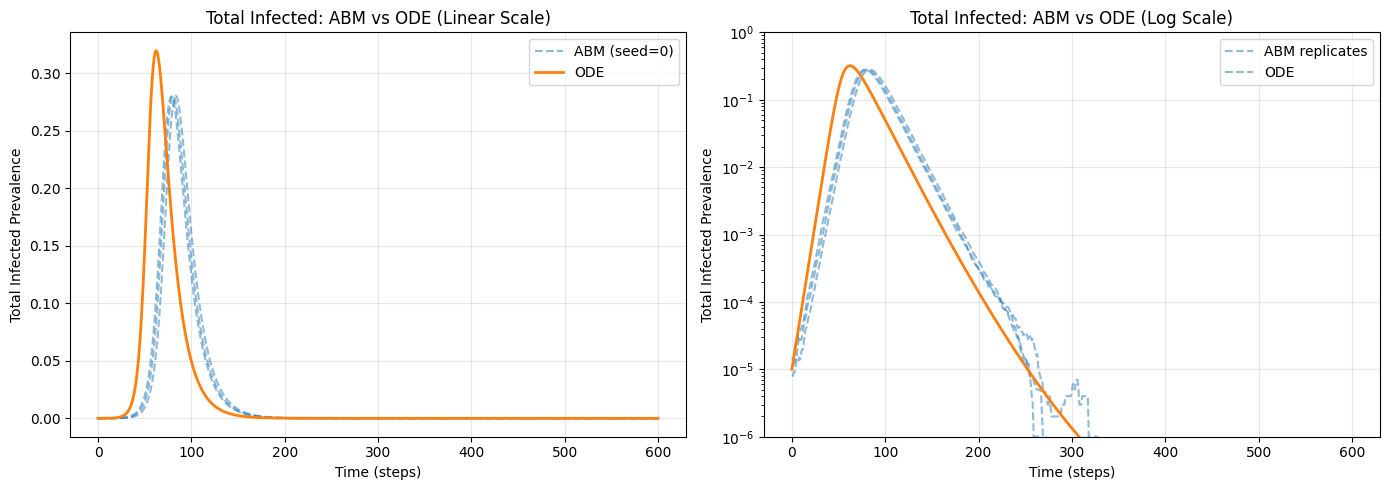

In [8]:
# Plot comparison of total infected over time
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Total infected (linear scale)
ax = axes[0]
# Plot ABM replicates
for seed in abm_df["Seed"].unique():
    subset = abm_df[abm_df["Seed"] == seed]
    ax.plot(
        subset["Time"],
        subset["Total_I"],
        alpha=0.5,
        linestyle="--",
        label=f"ABM (seed={seed})" if seed == 0 else None,
        color="C0",
    )
# Plot ODE
ax.plot(
    ode_df["Time"],
    ode_df["Total_I"],
    linewidth=2,
    label="ODE",
    color="C1",
)
ax.set_xlabel("Time (steps)")
ax.set_ylabel("Total Infected Prevalence")
ax.set_title("Total Infected: ABM vs ODE (Linear Scale)")
ax.legend()
ax.grid(True, alpha=0.3)

# Right plot: Total infected (log scale)
ax = axes[1]
for seed in abm_df["Seed"].unique():
    subset = abm_df[abm_df["Seed"] == seed]
    ax.plot(
        subset["Time"],
        subset["Total_I"],
        alpha=0.5,
        linestyle="--",
        color="C0",
    )
ax.plot(
    ode_df["Time"],
    ode_df["Total_I"],
    linewidth=2,
    label="ODE",
    color="C1",
)
ax.set_xlabel("Time (steps)")
ax.set_ylabel("Total Infected Prevalence")
ax.set_title("Total Infected: ABM vs ODE (Log Scale)")
ax.set_yscale("log")
ax.set_ylim(1 / POP_SIZE, 1)
ax.legend(["ABM replicates", "ODE"])
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

/tmp/ipykernel_4691/2751813595.py:36: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")


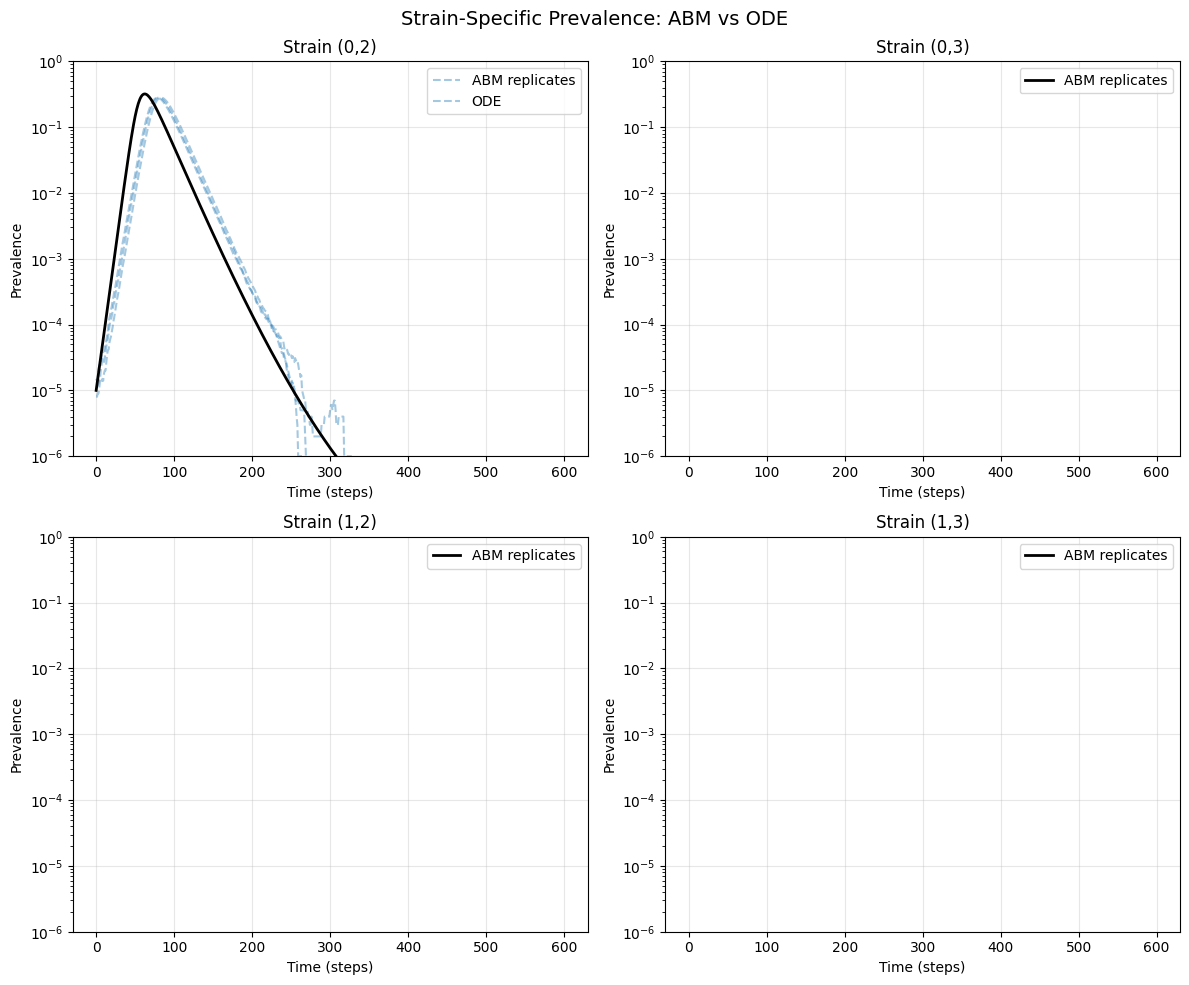

In [9]:
# Plot strain-specific comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

strain_columns = ["Strain_(0,2)", "Strain_(0,3)", "Strain_(1,2)", "Strain_(1,3)"]
strain_titles = ["Strain (0,2)", "Strain (0,3)", "Strain (1,2)", "Strain (1,3)"]
colors = ["C0", "C1", "C2", "C3"]

for idx, (strain_col, title) in enumerate(zip(strain_columns, strain_titles)):
    ax = axes[idx // 2, idx % 2]

    # Plot ABM replicates
    for seed in abm_df["Seed"].unique():
        subset = abm_df[abm_df["Seed"] == seed]
        if strain_col in subset.columns:
            ax.plot(
                subset["Time"],
                subset[strain_col],
                alpha=0.4,
                linestyle="--",
                color=colors[idx],
            )

    # Plot ODE
    if strain_col in ode_df.columns:
        ax.plot(
            ode_df["Time"],
            ode_df[strain_col],
            linewidth=2,
            color="black",
            label="ODE",
        )

    ax.set_xlabel("Time (steps)")
    ax.set_ylabel("Prevalence")
    ax.set_title(title)
    ax.set_yscale("log")
    ax.set_ylim(1 / POP_SIZE, 1)
    ax.legend(["ABM replicates", "ODE"])
    ax.grid(True, alpha=0.3)

plt.suptitle("Strain-Specific Prevalence: ABM vs ODE", fontsize=14)
plt.tight_layout()
plt.show()

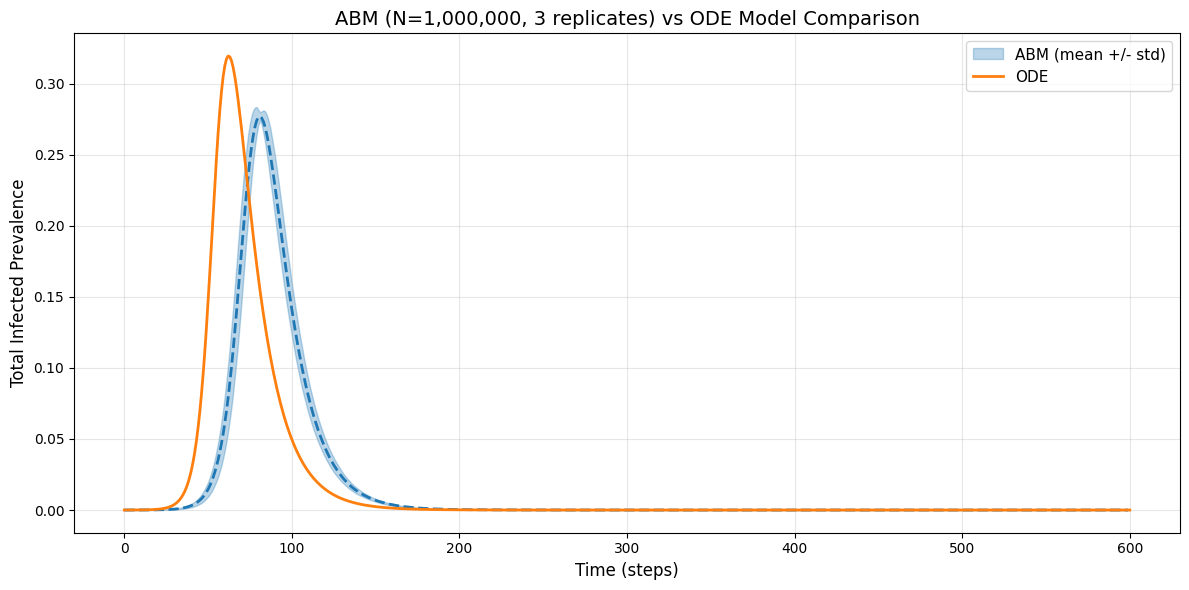

In [10]:
# Combined comparison with mean and confidence interval for ABM
fig, ax = plt.subplots(figsize=(12, 6))

# Calculate ABM mean and std
abm_grouped = abm_df.groupby("Time")["Total_I"].agg(["mean", "std"]).reset_index()

# Plot ABM mean with confidence band
ax.fill_between(
    abm_grouped["Time"],
    abm_grouped["mean"] - abm_grouped["std"],
    abm_grouped["mean"] + abm_grouped["std"],
    alpha=0.3,
    color="C0",
    label="ABM (mean +/- std)",
)
ax.plot(
    abm_grouped["Time"],
    abm_grouped["mean"],
    linewidth=2,
    color="C0",
    linestyle="--",
)

# Plot ODE
ax.plot(
    ode_df["Time"],
    ode_df["Total_I"],
    linewidth=2,
    color="C1",
    label="ODE",
)

ax.set_xlabel("Time (steps)", fontsize=12)
ax.set_ylabel("Total Infected Prevalence", fontsize=12)
ax.set_title(
    f"ABM (N={POP_SIZE:,}, {N_REP} replicates) vs ODE Model Comparison",
    fontsize=14,
)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# Print summary statistics
print("=" * 60)
print("Summary Statistics")
print("=" * 60)
print(f"\nODE Model:")
print(f"  Final total infected: {ode_df['Total_I'].iloc[-1]:.6e}")
print(f"  Peak infected: {ode_df['Total_I'].max():.6e}")
print(f"  Time of peak: {ode_df.loc[ode_df['Total_I'].idxmax(), 'Time']:.1f}")

print(f"\nABM Model (mean across {N_REP} replicates):")
abm_final = abm_df.groupby("Seed")["Total_I"].last()
print(f"  Final total infected: {abm_final.mean():.6e} +/- {abm_final.std():.6e}")

abm_peak = abm_df.groupby("Seed")["Total_I"].max()
print(f"  Peak infected: {abm_peak.mean():.6e} +/- {abm_peak.std():.6e}")

print("\n" + "=" * 60)

Summary Statistics

ODE Model:
  Final total infected: 1.783120e-07
  Peak infected: 3.194711e-01
  Time of peak: 62.0

ABM Model (mean across 3 replicates):
  Final total infected: 0.000000e+00 +/- 0.000000e+00
  Peak infected: 2.800993e-01 +/- 3.340963e-04

